<a href="https://colab.research.google.com/github/Aditib2409/EE-541-Project/blob/main/chords_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import numpy as np
import pandas as pd
import os
import torch 
import torchaudio
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram, find_peaks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/Shareddrives/EE541Project/archive.zip"

Archive:  /content/drive/Shareddrives/EE541Project/archive.zip
  inflating: Audio_Files/Major/Major_0.wav  
  inflating: Audio_Files/Major/Major_1.wav  
  inflating: Audio_Files/Major/Major_10.wav  
  inflating: Audio_Files/Major/Major_100.wav  
  inflating: Audio_Files/Major/Major_101.wav  
  inflating: Audio_Files/Major/Major_102.wav  
  inflating: Audio_Files/Major/Major_103.wav  
  inflating: Audio_Files/Major/Major_104.wav  
  inflating: Audio_Files/Major/Major_105.wav  
  inflating: Audio_Files/Major/Major_106.wav  
  inflating: Audio_Files/Major/Major_107.wav  
  inflating: Audio_Files/Major/Major_108.wav  
  inflating: Audio_Files/Major/Major_109.wav  
  inflating: Audio_Files/Major/Major_11.wav  
  inflating: Audio_Files/Major/Major_110.wav  
  inflating: Audio_Files/Major/Major_111.wav  
  inflating: Audio_Files/Major/Major_112.wav  
  inflating: Audio_Files/Major/Major_113.wav  
  inflating: Audio_Files/Major/Major_114.wav  
  inflating: Audio_Files/Major/Major_115.wav  
  i

### Loading Dataset

In [5]:
class loading_dataset:
    def __init__(self, path):
        self.path = path

    def harmonics(self, file_path, print=False):
        freq, X = wavfile.read(file_path)
        n = len(X)
        X_fourier = fft(X)
        X_fourier_onesided = 2.0/n * np.abs(X_fourier[0:n // 2])
        frequencies = fftfreq(n, 1/freq)[:n//2]
        freqs_50_index = np.argmin(np.abs(frequencies - 50))
        
        ht = np.max(X_fourier_onesided)*5/100
        peaks_found, _ = find_peaks(X_fourier_onesided, distance=10, height=ht)
        peaks_found = peaks_found[peaks_found>freqs_50_index]
        harmonics_found = np.round(frequencies[peaks_found],2)
        
        if print:
            p = np.max(peaks_found) + 100
            plt.plot(frequencies[:p], X_fourier_onesided[:p])
            plt.plot(frequencies[peaks_found], X_fourier_onesided[peaks_found], 'o')
            plt.xlabel(f'Frequency in Hz')
            plt.ylabel(f'Harmonics')
            plt.show()
        
        return harmonics_found

    
    def create_dataframe(self):
        # to track the length of a harmonic
        length_harmonic = 0
        dataset = []

        for dir_name, _, file_name in os.walk(self.path):
            for filename in file_name:
                folder_name = os.path.basename(dir_name)
                full_filepath = os.path.join(dir_name, filename)
                harmonic_peaks = self.harmonics(full_filepath)
                min_harmonics = harmonic_peaks.min()
                max_harmonics = harmonic_peaks.max()
                num_peaks = len(harmonic_peaks)
                length_harmonic = max(num_peaks, length_harmonic)
                current_data = [folder_name, filename, min_harmonics, max_harmonics, num_peaks] 
                current_data.extend(harmonic_peaks)

                dataset.append(current_data)

        feature_cols = ["Chord_type", "File_name", "Minimum_harmonic", "Maximum_harmonic", "Num_harmonics"]
        for i in range(length_harmonic):
            feature_cols.append(f'Harmonic {i+1}')

        data_df = pd.DataFrame(dataset, columns=feature_cols)

        return data_df

In [35]:
path = "/content/drive/MyDrive/Audio_Files"
path = "/content/Audio_Files"
dataloader = loading_dataset(path)
data = dataloader.create_dataframe()
data_og = data

In [7]:
def plot_kde(I, df):
    rows = len(I)
    fig, axes = plt.subplots(nrows=1, ncols=rows, figsize=(25, 3), sharex=True, sharey=True)
    axes = axes.ravel()
    for i in range(rows):
        if i <= len(I)-1:
            sns.kdeplot(ax=axes[i], data=df, x=I[i], hue="Chord_type", shade=True, palette="Set2")
    fig.suptitle(f'KDE plots of Selected Features')
    plt.savefig(f'/content/drive/Shareddrives/EE541Project/Figures/Data Preprocessing/kde_intervals.png')
    plt.show()

In [8]:
def plot_kde_features(I, df):
    fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(15, 35))
    axs = axes.ravel()
    for i in range(len(I)):
        if i <= len(I)-1:
            sns.kdeplot(ax=axs[i], data=df, x=I[i], hue="Chord_type", shade=True)
    plt.savefig(f'/content/drive/Shareddrives/EE541Project/Figures/Data Preprocessing/kde_features.png')
    plt.show()

### Creating intervals

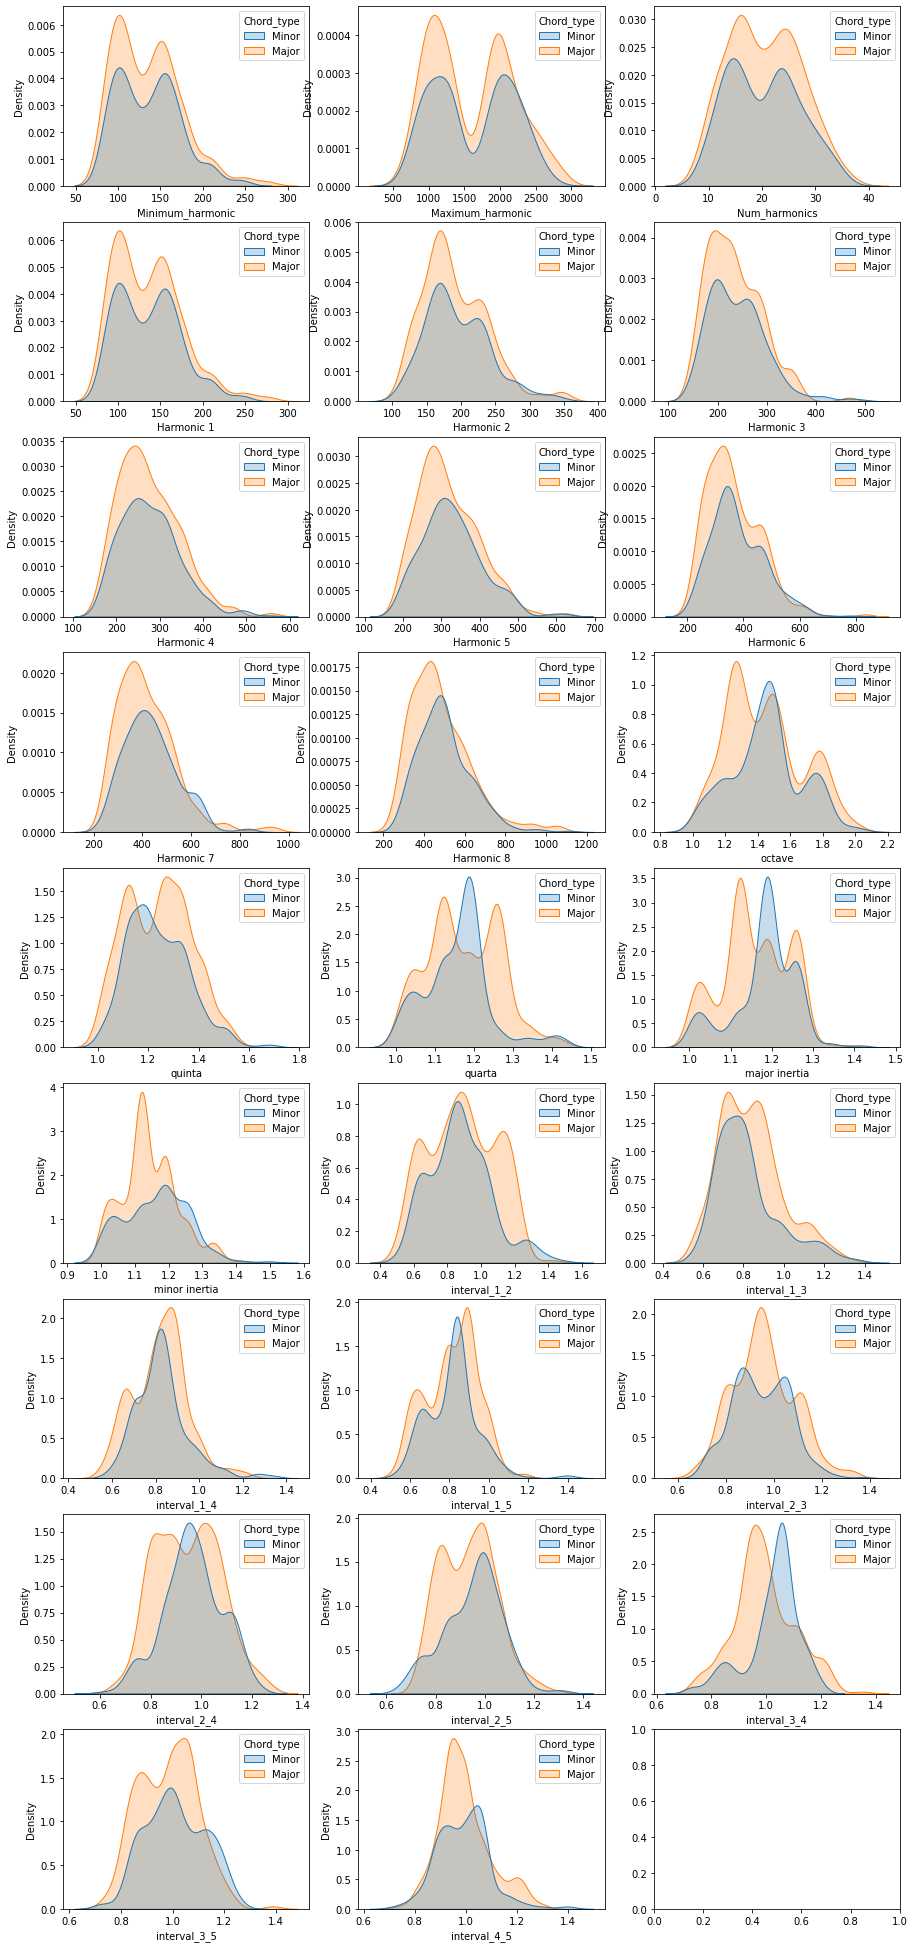

In [36]:
intervals = ["octave", "quinta", "quarta", "major inertia", "minor inertia"]
for i in range(len(intervals)):
    data[intervals[i]] = np.divide(data[f'Harmonic {i+2}'], data[f'Harmonic {i+1}'])

# adding more intervals
for i in range(len(intervals)):
    for j in range(i+1, len(intervals)):
        data[f'interval_{i+1}_{j+1}'] = np.divide(data[intervals[j]], data[intervals[i]])

## gives list of all harmonics that have NANs. we drop those harmonics
data.isnull().sum(axis = 0)

drop_harmonics = data.columns[13:43] ## NAN values
data = data.drop(drop_harmonics, axis=1)
data = data.drop("File_name", axis=1)
new_list = list(data.columns)
plot_kde_features(new_list[1:], data)
data["Chord_type"] = data["Chord_type"].replace("Major", 0)
data["Chord_type"] = data["Chord_type"].replace("Minor", 1)
data_y = data["Chord_type"]
new_data = data.drop("Chord_type", axis=1)

## Feature Selection

In [81]:
train_x, test_x, train_y, test_y = train_test_split(new_data, data_y, test_size=0.15, random_state=42)

In [82]:
test_csv = pd.concat([test_x, test_y], axis=1)
test_csv.to_csv("/content/drive/Shareddrives/EE541Project/Data/Test", encoding='utf-8', index=False)

In [83]:
def get_selected_features(df, y, df_test):
    data_x = df
    normalizer = StandardScaler()
    data_norm = normalizer.fit_transform(data_x)
    

    pca = PCA()
    data_pca = pca.fit_transform(data_norm)

    explained_variance = pca.explained_variance_ratio_
    plt.plot(explained_variance, marker='o', color='black')
    plt.title('Variances in each component')
    plt.xlabel('num of features')
    plt.ylabel('variances')

    for i in range(len(explained_variance)):
        sum_variances = explained_variance[0:i].sum()
        if sum_variances > 0.99:
            num_components = i
            break
    
    y0 = explained_variance[num_components]
    plt.plot(num_components, y0, marker='s', color='red', label=f"num_components={num_components}")
    plt.savefig(f'/content/drive/Shareddrives/EE541Project/Figures/Data Preprocessing/pca_variances.png')
    plt.legend()


    ## Recursive feature analysis
    model_tree = RandomForestClassifier(random_state=100, n_estimators=50)
    sel_rfe_tree = RFE(estimator=model_tree, n_features_to_select=num_components, step=1)
    X_train_rfe_tree = sel_rfe_tree.fit_transform(data_norm, y)
    sel_feature_indices = sel_rfe_tree.ranking_
    # print(sel_feature_indices)

    sel_columns = data_x.columns[np.where(sel_feature_indices == 1)]

    plot_kde(sel_columns, data)

    data_transformed_train = data_x[sel_columns]
    data_transformed_test = df_test[sel_columns]

    return data_transformed_train, data_transformed_test

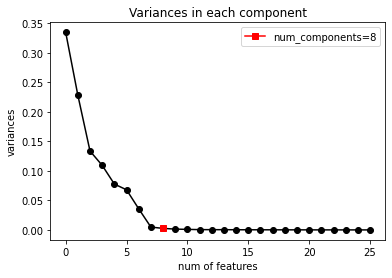

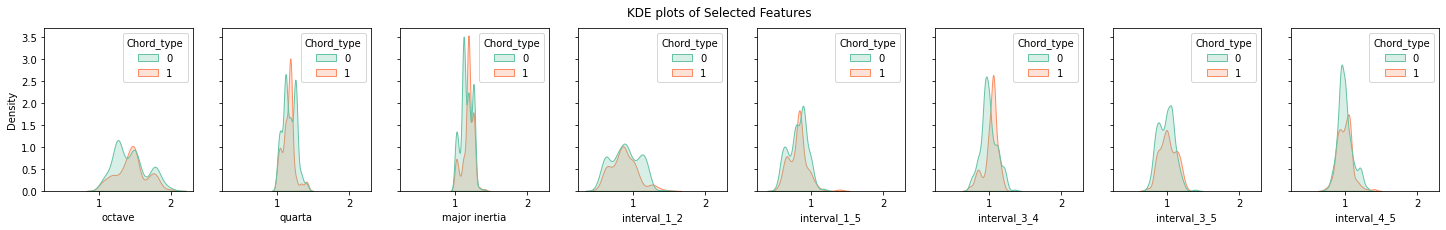

In [84]:
train_x, test_x  = get_selected_features(train_x, train_y, test_x)

In [91]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.20, shuffle=True)

In [92]:
train_csv = pd.concat([train_x, train_y], axis=1)
val_csv = pd.concat([val_x, val_y], axis=1)
train_csv.to_csv("/content/drive/Shareddrives/EE541Project/Data/Train", encoding='utf-8', index=False)
val_csv.to_csv("/content/drive/Shareddrives/EE541Project/Data/Val", encoding='utf-8', index=False)

# Model Implementation


In [93]:
X_train = train_x
Y_train = train_y
X_test = val_x
Y_test = val_y

In [94]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score

cv = KFold(n_splits=10, random_state=1, shuffle=True)

# Functions
def calcAccuracy(labels, preds):
    return np.mean(labels == preds)

def plotConfMat(labels, preds):
    confmat = confusion_matrix(labels, preds)
    p = sns.heatmap(confmat, annot=True, fmt='g')
    p.set_xlabel("Prediction", fontsize = 20)
    p.set_ylabel("Reference", fontsize = 20)
    return p


# Random Forest
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

rf.fit(X_train, Y_train)
rf_pred = rf.predict(X_test)

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, Y_train)
nb_pred = nb.predict(X_test)
scores_nb = cross_val_score(nb, X_train, Y_train, scoring='accuracy', cv=cv)
# SVM:
svc_l = SVC(C=2, kernel='linear')     # Linear kernel
svc_p = SVC(C=2, kernel='poly') # polynomial kernel
svc_r = SVC(C=2, kernel='rbf')        # radial kernel

svc_l.fit(X_train, Y_train)
svc_l_pred = svc_l.predict(X_test)
scores_svc_l = cross_val_score(svc_l, X_train, Y_train, scoring='accuracy', cv=cv)

svc_p.fit(X_train, Y_train)
svc_p_pred = svc_p.predict(X_test)
scores_svc_p = cross_val_score(svc_p, X_train, Y_train, scoring='accuracy', cv=cv)

svc_r.fit(X_train, Y_train)
svc_r_pred = svc_r.predict(X_test)
scores_svc_r = cross_val_score(svc_r, X_train, Y_train, scoring='accuracy', cv=cv)

In [95]:
print("Naive Bayes:", calcAccuracy(Y_test, nb_pred))
print("SVM Linear:", calcAccuracy(Y_test, svc_l_pred))
print("SVM Polynomial:", calcAccuracy(Y_test, svc_p_pred))
print("SVM Radial:", calcAccuracy(Y_test, svc_r_pred))

Naive Bayes: 0.6239316239316239
SVM Linear: 0.6153846153846154
SVM Polynomial: 0.6837606837606838
SVM Radial: 0.6153846153846154
